# Rate Sentiment Analysis

## Dependencies

In [1]:
!pip install ktrain
!pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     - 0 bytes ? 0:00:00
     - 11.7 kB ? 0:00:00
     \ 29.0 kB 344.9 kB/s 0:00:00
     \ 57.8 kB 445.3 kB/s 0:00:00
     | 97.4 kB 557.0 kB/s 0:00:00
     | 139.1 kB 628.5 kB/s 0:00:00
     / 231.2 kB 815.3 kB/s 0:00:00
     / 357.7 kB 1.1 MB/s 0:00:00
     - 486.2 kB 1.3 MB/s 0:00:00
     - 595.4 kB 1.5 MB/s 0:00:00
     \ 706.5 kB 1.5 MB/s 0:00:00
     \ 826.5 kB 1.6 MB/s 0:00:00
     | 964.9 kB 1.7 MB/s 0:00:00
     / 1.1 MB 1.8 MB/s 0:00:00
     / 1.3 MB 1.9 MB/s 0:00:00
     - 1.4 MB 2.0 MB/s 0:00:00
     - 1.5 MB 2.0 MB/s 0:00:00
     \ 1.7 MB 2.1 MB/s 0:00:00
     \ 1.8 MB 2.2 MB/s 0:00:00
     | 2.0 MB 2.2 MB/s 0:00:00
     | 2.1 MB 2.2 MB/s 0:00:00
     / 2.2 MB 2.2 MB/s 0:00:00
     / 2.3 MB 2.2 MB/s 0:00:01
     - 2.4 MB 2.2 MB/s 0:00:01
     - 2.5 MB 2.2 MB/s 0:00:01
     \ 2.6 MB 2.2 MB/s 0:00:01
     | 2.8 MB 2.3 MB/s 0:00:01
     | 2.9 MB 2.3 MB/s 0

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import ktrain
import eli5
import jieba
from ktrain import text
import matplotlib.pyplot as plt
import pickle

## Data Preparation

In [2]:
data_train = pd.read_csv('datasets/train.csv')[['review','star']]
data_test = pd.read_csv('datasets/test.csv')[['review','star']]
data_val = pd.read_csv('datasets/dev.csv')[['review','star']]

In [3]:
#构建label值
def star2sen(score):
    if score > 3:
        return '1'
    elif score == 3:
        return None
    elif score < 3:
        return '-1'
    else:
        return None
    
#特征值转换
data_train['sentiment'] = data_train['star'].map(lambda x: star2sen(x))
data_train.dropna(inplace = True)
data_val['sentiment'] = data_val['star'].map(lambda x: star2sen(x))
data_val.dropna(inplace = True)
data_test['sentiment'] = data_test['star'].map(lambda x: star2sen(x))
data_test.dropna(inplace = True)

## LR

### Tokenization & Vectorization

In [4]:
#引入停用词
infile = open("stopwords-zh.txt",encoding='utf-8')
stopwords_lst = infile.readlines()
stopwords = [x.strip() for x in stopwords_lst]

#中文分词
def tokenization_dataset(train_data):
    tokenized_df = train_data.apply(lambda x:' '.join(jieba.cut(x)))
    return tokenized_df

def tokenization_text(text):
    tokenized_text = ' '.join(jieba.cut(text))
    return tokenized_text

In [5]:
x_train_lr = tokenization_dataset(data_train["review"])
y_train_lr = data_train['sentiment']
x_val_lr = tokenization_dataset(data_val["review"])
y_val_lr = data_val['sentiment']
x_test_lr = tokenization_dataset(data_test["review"])
y_test_lr = data_test['sentiment']

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\miuGrey\AppData\Local\Temp\jieba.cache
Loading model cost 0.625 seconds.
Prefix dict has been built successfully.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
#使用tf-idf把文本转为向量
tv = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)
tv.fit(x_train_lr)

TfidfVectorizer(lowercase=False, max_features=30000,
                stop_words=['$', '0', '1', '2', '3', '4', '5', '6', '7', '8',
                            '9', '?', '_', '“', '”', '、', '。', '《', '》', '一',
                            '一些', '一何', '一切', '一则', '一方面', '一旦', '一来', '一样',
                            '一般', '一转眼', ...])

### Train

In [7]:
#LR
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(tv.transform(x_train_lr), y_train_lr)
model_lr.score(tv.transform(x_val_lr), y_val_lr)

0.9564485081809432

### Evaluation for LR Model

In [8]:
y_pred_lr = model_lr.predict(tv.transform(x_test_lr))

In [9]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_lr, y_pred_lr))

              precision    recall  f1-score   support

          -1       0.98      0.49      0.65       338
           1       0.96      1.00      0.98      3885

    accuracy                           0.96      4223
   macro avg       0.97      0.74      0.81      4223
weighted avg       0.96      0.96      0.95      4223



In [10]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_lr, y_pred_lr)

array([[ 165,  173],
       [   4, 3881]], dtype=int64)

In [11]:
def lr_explain(model, sentence):
    return eli5.show_prediction(model, tokenization_text(sentence), vec=tv, feature_names=tv.get_feature_names_out())

In [12]:
data_test.iloc[536]

review       吃帝王蟹的专门店，门口就挂着巨大无比的螃蟹，同行的盆友们想吃帝王蟹，我们就按着大众点评找过来...
star                                                       5.0
sentiment                                                    1
Name: 606, dtype: object

In [13]:
lr_explain(model_lr, data_test.iloc[536]['review'])

In [14]:
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手扶梯旁。'

In [15]:
lr_explain(model_lr, test1)

In [16]:
lr_explain(model_lr, test2)  # 错误分类

In [17]:
lr_explain(model_lr, test3)  # 这都能给4星

## LR Oversampling

### Dataset Oversampling

In [6]:
data_train["sentiment"].value_counts()

1     29132
-1     2477
Name: sentiment, dtype: int64

In [7]:
mask_neg = data_train["sentiment"] == '-1'
mask_pos = data_train["sentiment"] == '1'

data_train_neg = data_train[mask_neg]
data_train_pos = data_train[mask_pos]

data_train_neg_oversamp = pd.concat([data_train_neg,data_train_neg,data_train_neg,data_train_neg,data_train_neg,data_train_neg,data_train_neg,data_train_neg,data_train_neg,data_train_neg,data_train_neg,data_train_neg])
data_train_oversamp = pd.concat([data_train_pos,data_train_neg_oversamp],axis=0,ignore_index=True)
data_train_oversamp["sentiment"].value_counts()

-1    29724
1     29132
Name: sentiment, dtype: int64

In [8]:
x_train_lr_oversamp = tokenization_dataset(data_train_oversamp["review"])
y_train_lr_oversamp = data_train_oversamp['sentiment']

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv_oversamp = TfidfVectorizer(stop_words=stopwords, max_features=30000, lowercase = False)
tv_oversamp.fit(x_train_lr_oversamp)

# 保存模型
with open('LR_model_rate/tv_model.pickle', 'wb') as f:
    pickle.dump(tv_oversamp, f)

### Train Oversampled Dataset

In [13]:
#LR
from sklearn.linear_model import LogisticRegression
model_lr_oversamp = LogisticRegression(max_iter=10000)
model_lr_oversamp.fit(tv_oversamp.transform(x_train_lr_oversamp), y_train_lr_oversamp)
model_lr_oversamp.score(tv_oversamp.transform(x_val_lr), y_val_lr)

with open('LR_model_rate/model_rate_LR.pickle','wb') as f: 
    pickle.dump(model_lr_oversamp,f) 

### Evaluation for Oversampled LR Model

In [25]:
y_pred_lr = model_lr_oversamp.predict(tv_oversamp.transform(x_test_lr))

In [26]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_lr, y_pred_lr))

              precision    recall  f1-score   support

          -1       0.60      0.85      0.70       338
           1       0.99      0.95      0.97      3885

    accuracy                           0.94      4223
   macro avg       0.79      0.90      0.84      4223
weighted avg       0.96      0.94      0.95      4223



In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_lr, y_pred_lr)

array([[ 288,   50],
       [ 193, 3692]], dtype=int64)

In [28]:
data_test.iloc[536]

review       吃帝王蟹的专门店，门口就挂着巨大无比的螃蟹，同行的盆友们想吃帝王蟹，我们就按着大众点评找过来...
star                                                       5.0
sentiment                                                    1
Name: 606, dtype: object

In [29]:
lr_explain(model_lr_oversamp, data_test.iloc[536]['review'])

In [30]:
lr_explain(model_lr_oversamp, test1) 

In [31]:
lr_explain(model_lr_oversamp, test2)

In [32]:
lr_explain(model_lr_oversamp, test3)  # 这都能给4星

## Bert

For a GPU with 12GB of RAM, the following maxima apply:

        sequence len=64, max_batch_size=64
        sequence len=128, max_batch_size=32
        sequence len=256, max_batch_size=16
        sequence len=320, max_batch_size=14
        sequence len=384, max_batch_size=12
        sequence len=512, max_batch_size=6

### Sentences length

<function matplotlib.pyplot.show(close=None, block=None)>

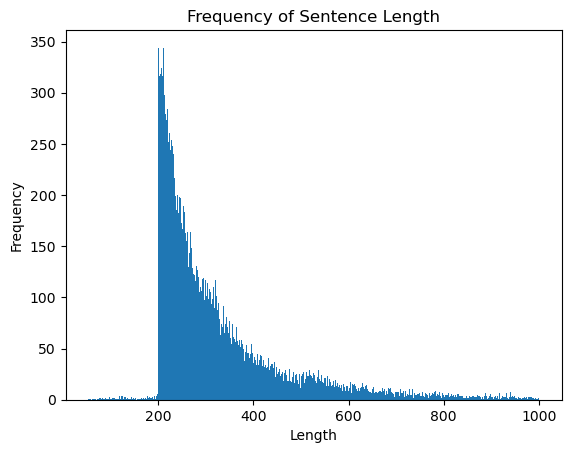

In [ ]:
data_train['length'] = data_train['review'].apply(lambda x: len(x))
len_train = data_train.groupby('length').count()

data_val['length'] = data_val['review'].apply(lambda x: len(x))
len_val = data_val.groupby('length').count()

data_test['length'] = data_test['review'].apply(lambda x: len(x))
len_test = data_test.groupby('length').count()

sent_length = len_train.index.tolist() + len_val.index.tolist() + len_test.index.tolist()
sent_freq = len_train['review'].tolist() + len_val['review'].tolist() + len_test['review'].tolist()

# 绘制句子长度及出现频数统计图
plt.bar(sent_length, sent_freq,2)
plt.title("Frequency of Sentence Length")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.savefig("sentence_length.png")
plt.show

### Data Preparation, Tokenization & Vectorization

In [ ]:
(X_train_bert, y_train_bert), (X_val_bert, y_val_bert), preproc_bert = text.texts_from_df(train_df=data_train,
                                                                   text_column = 'review',
                                                                   label_columns = 'sentiment',
                                                                   val_df = data_val,
                                                                   maxlen = 256,
                                                                   max_features=30000,
                                                                   preprocess_mode = 'bert')

['-1', '1']
    -1    1
0  0.0  1.0
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0
['-1', '1']
    -1    1
0  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0
6  0.0  1.0
preprocessing train...
language: zh-cn


Is Multi-Label? False
preprocessing test...
language: zh-cn


### Train

In [ ]:
model_bert = text.text_classifier(name = 'bert',
                             train_data = (X_train_bert, y_train_bert),
                             preproc = preproc_bert)

Is Multi-Label? False
maxlen is 256
done.


In [ ]:
learner_bert = ktrain.get_learner(model=model_bert, train_data=(X_train_bert, y_train_bert),
                   val_data = (X_val_bert, y_val_bert),
                   batch_size = 16)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
1976/1976 [==============================] - 509s 248ms/step - loss: 0.2007 - accuracy: 0.9371
Epoch 2/2
1976/1976 [==============================] - 181s 92ms/step - loss: 0.8453 - accuracy: 0.8937


done.
Visually inspect loss plot and select learning rate associated with falling loss
Three possible suggestions for LR from plot:
	Longest valley (red): 4.01E-06
	Min numerical gradient (purple): 1.12E-07
	Min loss divided by 10 (omitted from plot): 1.42E-05


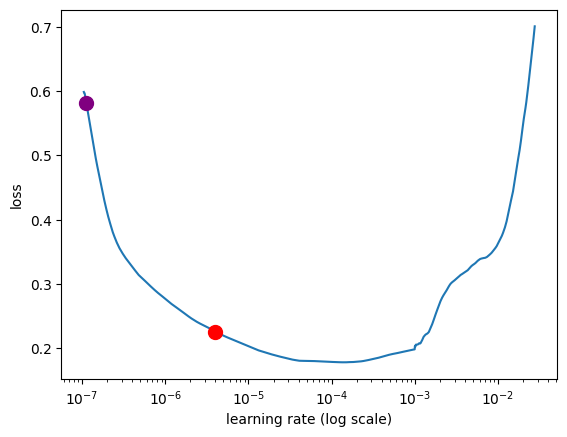

In [ ]:
# 自动寻找lr
# https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/
learner_bert.lr_find(show_plot=True, suggest=True, max_epochs = 2)

In [ ]:
learner_bert.autofit(lr = 5.12E-07, checkpoint_folder='bert-meituan-rate/tmp')
predictor_bert = ktrain.get_predictor(learner_bert.model, preproc_bert)
predictor_bert.save('bert-meituan-rate')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5.12e-07...
Epoch 1/1024
1976/1976 [==============================] - 531s 261ms/step - loss: 0.1831 - accuracy: 0.9402 - val_loss: 0.1160 - val_accuracy: 0.9629
Epoch 2/1024
1976/1976 [==============================] - 514s 260ms/step - loss: 0.1021 - accuracy: 0.9655 - val_loss: 0.1003 - val_accuracy: 0.9678
Epoch 3/1024
1976/1976 [==============================] - 514s 260ms/step - loss: 0.0910 - accuracy: 0.9691 - val_loss: 0.0951 - val_accuracy: 0.9694
Epoch 4/1024
1976/1976 [==============================] - 520s 263ms/step - loss: 0.0841 - accuracy: 0.9719 - val_loss: 0.0925 - val_accuracy: 0.9709
Epoch 5/1024
1976/1976 [==============================] - 527s 266ms/step - loss: 0.0794 - accuracy: 0.9733 - val_loss: 0.0907 - val_accuracy: 0.9709
Epoch 6/1024
1976/1976 [==============================] - 529s 

### Evaluation for Bert Model

In [ ]:
X_test_bert = data_test['review']
y_test_bert = data_test['sentiment']
y_pred_bert=predictor_bert.predict(X_test_bert.values)

In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_bert, y_pred_bert))

              precision    recall  f1-score   support

          -1       0.87      0.75      0.81       338
           1       0.98      0.99      0.98      3885

    accuracy                           0.97      4223
   macro avg       0.92      0.87      0.90      4223
weighted avg       0.97      0.97      0.97      4223



In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_bert, y_pred_bert)

array([[ 255,   83],
       [  39, 3846]], dtype=int64)

In [ ]:
data_test.iloc[536]

review       吃帝王蟹的专门店，门口就挂着巨大无比的螃蟹，同行的盆友们想吃帝王蟹，我们就按着大众点评找过来...
star                                                       5.0
sentiment                                                    1
Name: 606, dtype: object

In [ ]:
predictor_bert.explain(data_test.iloc[536]['review'])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\revce\AppData\Local\Temp\jieba.cache
Loading model cost 0.666 seconds.
Prefix dict has been built successfully.


In [ ]:
#从大众点评网找两条评论来测试一下
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手扶梯旁。'

In [ ]:
predictor_bert.explain(test1)

In [ ]:
predictor_bert.explain(test2)

In [ ]:
predictor_bert.explain(test3) # 被截断

## Bert Oversampling

### Data Preparation, Tokenization & Vectorization

In [ ]:
(X_train_bert_oversamp, y_train_bert_oversamp), (X_val_bert, y_val_bert), preproc_bert_oversamp = text.texts_from_df(
                                                                   train_df=data_train_oversamp,
                                                                   text_column = 'review',
                                                                   label_columns = 'sentiment',
                                                                   val_df = data_val,
                                                                   maxlen = 256,
                                                                   max_features=30000,
                                                                   preprocess_mode = 'bert')

['-1', '1']
    -1    1
0  0.0  1.0
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0
['-1', '1']
    -1    1
0  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0
6  0.0  1.0
preprocessing train...
language: zh-cn


Is Multi-Label? False
preprocessing test...
language: zh-cn


### Train

In [ ]:
model_bert_oversamp = text.text_classifier(name = 'bert',
                             train_data = (X_train_bert_oversamp, y_train_bert_oversamp),
                             preproc = preproc_bert_oversamp)

Is Multi-Label? False
maxlen is 256
done.


In [ ]:
learner_bert_oversamp = ktrain.get_learner(model=model_bert_oversamp, train_data=(X_train_bert_oversamp, y_train_bert_oversamp),
                   val_data = (X_val_bert, y_val_bert),
                   batch_size = 16)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
3679/3679 [==============================] - 981s 262ms/step - loss: 0.3918 - accuracy: 0.8091
Epoch 2/2
3679/3679 [==============================] - 361s 98ms/step - loss: 1.4166 - accuracy: 0.4997


done.
Visually inspect loss plot and select learning rate associated with falling loss
Three possible suggestions for LR from plot:
	Longest valley (red): 5.02E-06
	Min numerical gradient (purple): 1.43E-07
	Min loss divided by 10 (omitted from plot): 2.40E-05


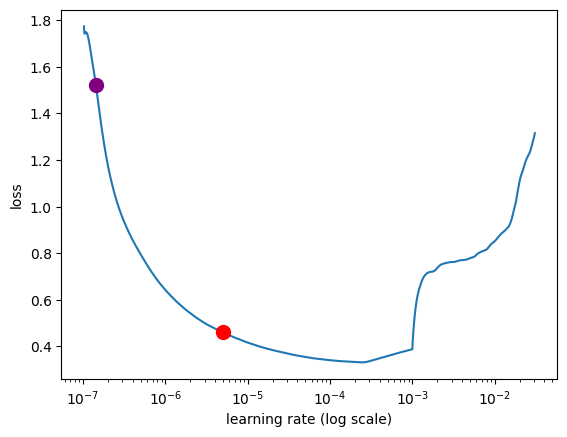

In [ ]:
# 自动寻找lr
# https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/
learner_bert_oversamp.lr_find(show_plot=True, suggest=True, max_epochs = 2)

In [ ]:
learner_bert_oversamp.autofit(lr = 5E-07, checkpoint_folder='bert-oversamp-meituan-rate/tmp')
predictor_bert_oversamp = ktrain.get_predictor(learner_bert_oversamp.model, preproc_bert_oversamp)
predictor_bert_oversamp.save('bert-oversamp-meituan-rate')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-07...
Epoch 1/1024
3679/3679 [==============================] - 1002s 267ms/step - loss: 0.3075 - accuracy: 0.8639 - val_loss: 0.1789 - val_accuracy: 0.9319
Epoch 2/1024
3679/3679 [==============================] - 991s 269ms/step - loss: 0.1704 - accuracy: 0.9330 - val_loss: 0.1580 - val_accuracy: 0.9377
Epoch 3/1024
3679/3679 [==============================] - 1002s 272ms/step - loss: 0.1356 - accuracy: 0.9480 - val_loss: 0.1436 - val_accuracy: 0.9463
Epoch 4/1024
3679/3679 [==============================] - 990s 269ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.1465 - val_accuracy: 0.9475
Epoch 5/1024
3679/3679 [==============================] - 992s 270ms/step - loss: 0.0853 - accuracy: 0.9708 - val_loss: 0.1314 - val_accuracy: 0.9562
Epoch 6/1024
3679/3679 [==============================] - 987s 2

### Evaluation for Oversampled Bert Model

In [ ]:
X_test_bert = data_test['review']
y_test_bert = data_test['sentiment']
y_pred_bert_oversamp = predictor_bert_oversamp.predict(X_test_bert.values)

In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_bert, y_pred_bert_oversamp))

              precision    recall  f1-score   support

          -1       0.73      0.83      0.77       338
           1       0.98      0.97      0.98      3885

    accuracy                           0.96      4223
   macro avg       0.86      0.90      0.88      4223
weighted avg       0.96      0.96      0.96      4223



In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_bert, y_pred_bert_oversamp)

array([[ 279,   59],
       [ 104, 3781]], dtype=int64)

In [ ]:
data_test.iloc[536]

review       吃帝王蟹的专门店，门口就挂着巨大无比的螃蟹，同行的盆友们想吃帝王蟹，我们就按着大众点评找过来...
star                                                       5.0
sentiment                                                    1
Name: 606, dtype: object

In [ ]:
predictor_bert_oversamp.explain(data_test.iloc[536]['review'])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\revce\AppData\Local\Temp\jieba.cache
Loading model cost 0.894 seconds.
Prefix dict has been built successfully.


In [ ]:
#从大众点评网找两条评论来测试一下
test1 = '很好吃，环境好，所有员工的态度都很好，上菜快，服务也很好，味道好吃，都是用蒸馏水煮的，推荐，超好吃' #5星好评
test2 = '糯米外皮不绵滑，豆沙馅粗躁，没有香甜味。12元一碗不值。' #1星差评
# 4星，搅屎棍
test3 = '昨儿晚上来凯德1818的绿茶吃饭，点了以下10个菜，这里面有好几个都是推荐菜品，咱挨个说啊～  第一张 “客家茄子煲”：一个字：咸、俩字：很咸、仨字：非常咸、四个字：咸（hou)死我了... ... 我很怀疑是不是师傅在放酱油的时候手抖了 然后整锅煲就是一锅酱色。里面的咸鱼粒很显然没有经过任何处理（泡一下水去掉部分盐分等），再加之菜本身很咸根本无法入口，整锅煲基本没动；第二张 “鱼头诱惑 ”：这道菜是翔哥点的 还不错 首先鱼头很新鲜 其次鱼头蒸的火候刚好 既入味还不老，建议除了小米辣再加上点泡椒，这样无论是颜色和口味上都会更棒的！这道菜基本消灭； 第三张：“小锅土豆”：厚片的土豆挂满酱汁，炉子在下面慢慢加热，后来加一片放到嘴里，几乎是入口即化、口感绵软，也是一道不错的下饭菜；第四张：“农家小菜”其实就是少了橄榄菜和肉末的豆角粒，味道还可以，如果把豆角再煸的干一点（表皮起皱）口感会更好；第五张“菜心金钩豆腐” 和没上图的“老乡浓汤”一起说了，两道分不清是汤、羹还是菜的东东，都是推荐菜 分不清也无所谓，重点是上菜的时候都不是热的 都是温的 “菜心”里面有蛋黄、“浓汤”里面有猪肚，这两种食材变冷后都会有腥味且口感不好，加之一碗有淀粉类的羹 温温的很难喝，建议出品后马上传菜到客人面前，口味上冷了就都不美味了；第六张：“麻酱油麦菜”很多地方也叫“麻酱凤尾” 麻酱用的像是麻酱和花生酱混合的甜口的酱料，重点是没有稀释！整个一坨粘在油麦菜上 根本拌不开 相比甜口的麻酱我更喜欢热干面那种咸口的、稀点儿的；第七张“面包诱惑”：这道是敬菜，口味还不错，冰淇淋也很好吃 就是卖相太一般了 既然要推广 至少要给点儿装饰，不用太复杂 拉个巧克力线条、给个蛋卷、水果粒稍稍点缀一下就会好看很多 面包本身口感和冰淇淋都很好吃 比很多外面装饰的那种美美的好吃多了 就差了一点装饰；第八张“绿茶烤鸡”很多人点这道菜，相比前几道的重口，烤鸡显得淡了一些。鸡皮的保护基本没有 所以整个鸡肉又干有柴、也挂不住调味料、下次有机会点个整只的或许会好一点；最后还有未上图的绿茶饼和糖醋里脊，绿茶饼还不错 可以一试 只要火候控制的好不炸过基本没问题，里面糯糯的馅儿很好吃；“糖醋里脊” 这是我吃过最难吃的版本，没有之一！上次有一小哥吐了一通槽 我还想就一个糖醋里脊也不是啥难菜 不至于吧 这次就抱着猎奇的心里点了一个 菜刚上来我就后悔了---老抽色（shai）的、外面一圈淀粉（粉面子）基本没吃着肉，糊哒哒粘成一坨 看起来和那个茄子煲没什么太大区别。建议找一个做糖醋里脊的店吃一次 看一看 就上个浆 过个油 浇个汁儿的事情 没那么难  肉类的菜品价格可以适当调高一些 我宁可多花点儿钱吃肉也不想吃这一坨坨粉面子。 总体而言环境还不错 价格很平民 服务中规中矩 但是菜品质量很是有待提高。看墙上的照片（不知道老板是不是做青旅起家的）菜品不会因为价格低而有销路 只会因为质量好才畅销（相比低价 现在的人们更喜欢质量好而有保障的食品 价格好一点反而是保证） 希望越做越好。地址在凯德1818  5楼手扶梯旁。'

In [ ]:
predictor_bert_oversamp.explain(test1)

In [ ]:
predictor_bert_oversamp.explain(test2)

In [ ]:
predictor_bert_oversamp.explain(test3) # 被截断